# Part 1: Getting the data

In [32]:
# Load necessary libraries here
import pandas as pd
import os
import math
import html
import re
import json  # for dumping and restoring data
import matplotlib.pyplot as plt
import random
import csv
import numpy as np
import networkx as nx
from itertools import combinations
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
import collections

from collections import defaultdict

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))
reviews_path = 'reviews/'
labmt = dict()  # the data structure used for sentiment analysis

with open('Data_Set_S1.txt', 'r') as csvf:
    data = csv.DictReader(csvf, delimiter='\t')
    for row in data:
        labmt[row['word']] = row['happiness_average']

[nltk_data] Downloading package stopwords to /home/kls/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The very first thing we do is loading the data set into Pandas data frames so that we may work with it. The data set is split into two files that needs to be joined. For this the `merge()` method is used, and we also add a column to indicate whether the review data has been fetched for each title. This is due to the fact that scraping reviews off the Internet is a process that might take some time and could be interrupted while it is in progress. There is no easy way to check if all reviews where fetched and saved to the database.

In [2]:
imdb_basic = 'title.basics.tsv'
imdb_ratings = 'title.ratings.tsv'

df = pd.read_csv(imdb_basic, sep='\t')

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
ratings = pd.read_csv(imdb_ratings, sep='\t')

# we are interested with the 3000 most rated titles
ratings = ratings.sort_values(by=['numVotes'], ascending=False)[:3000]

In [4]:
df = pd.merge(df, ratings, on='tconst')

In [5]:
def scrape_reviews(imdb_id):
    # Initialize empty dataframe to save reviews in
    column_titles = ['tconst', 'rating', 'username', 'date', 'title', 'text']
    review_texts = pd.DataFrame(columns=column_titles)
    
    # use selenium to get the review webpage
    driver = webdriver.Chrome('chromedriver')
    driver.get(f'https://www.imdb.com/title/{imdb_id}/reviews')

    # keep clicking the load more button to show all reviews
    while (True):
        loadbutton = driver.find_element_by_id("load-more-trigger").click()
        try:
            #print("Loading more reviews")
            element = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.ID, "load-more-trigger"))
            )
            continue
        except:
            break

    #print("done")

    # inject page source into BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # get number of reviews for sanity checking  if needed
    num_reviews_text = soup.find('div', attrs={'class':'header'}).find('span').text
    num_reviews = int(''.join(num_reviews_text.split()[0].split(','))) # convert from string to int

    # routine below finds all reviews and treats them with some dataframe love
    review_soup = soup.find_all('div', attrs={'class': 'lister-item-content'})

    reviews = []
    for r in review_soup:
        # find elements of the review in the web page and save
        # them as a dict for later processing
        rating = None
        try:
            rating = r.find('span', attrs={'class': 'rating-other-user-rating'}).find('span').text
        except:
            rating = None  # for some reason some IMDb user reviews doesn't contain a score
        rv = {
            'tconst': imdb_id,
            'rating': rating,
            'username': r.find('div', attrs={'class': 'display-name-date'}).find('a').text,
            'text': r.find('div', attrs={'class': 'text'}).text,
            'title': r.find('a', attrs={'class': 'title'}).text,
            'date': r.find('span', attrs={'class': 'review-date'}).text
        }
    
        reviews.append(rv)
    
    review_texts = review_texts.append(pd.DataFrame(reviews))
    if len(review_texts) < math.ceil(0.95*num_reviews):
        # some times the function would fetch only a subset of the reviews
        print("Got", len(review_texts), '/', num_reviews, 'reviews. Please run the function again')
    else:
        print("Saving TSV file for", imdb_id, ".")
        review_texts.to_csv(reviews_path+imdb_id+'.tsv', sep='\t')

In [ ]:
scrape_reviews('tt0903624')  # test scrape The Hobbit

In [6]:
test_scrape = pd.read_csv(reviews_path + 'tt0903624.tsv', sep='\t')

In [7]:
# print the text of the reviews loaded from disk
test_scrape.loc[0].text

"When I heard that there was to be a film version of The Hobbit, I was quite looking forward to it as the big finish of Lord of the Rings was still in my mind and, unlike LotR, I had actually read The Hobbit several times many years ago. When I heard that it might be two films I wasn't surprised but the news that it was to be three did rather dampen my spirits as I don't know if I had the interest for this story to be concluded as 2016 rolls into town. Regardless I did of course watch the film because it is still a large blockbuster and, at a time of the year normally filled with overly earnest Oscar contenders, I did quite like the idea of returning to this world again.With this in mind I did wonder why I watched it with a surprisingly detached air and why I wasn't able to get into it like I should have done. I had some reservations with the first film in the LotR trilogy but this seemed different because it certainly wasn't a lack of action and forward motion that gave me a problem h

With the method for scraping reviews tested out, we prepare to scrape reviews for all titles in the dataframe.

In [ ]:
def scrape_all_titles():
    """ Scrapes reviews for all titles in the Pandas dataframe """
    num_fetched = 0
    
    for _, title in df.iterrows():
        print('Fetching', num_fetched, '/', len(df))
        
        num_fetched += 1
        
        # check if title has been scraped if yes then skip it
        if os.path.exists(reviews_path + title.tconst + '.tsv'):
            continue
            
        scrape_reviews(title.tconst)
    
scrape_all_titles()

# Part 2: Basic data set insight

To get an idea of what the dataset we work with contains, we will begin by loading it into Pandas dataframes to inspect the first handful of rows. We chose to work with movie related data because we both enjoy watching movies and tv shows and are often influenced by opinions found on sites like IMDb, Rotten Tomatoes and so on when we are looking for new stuff to watch. We especially find user generated data on these kind of sites interesting, as so far we think that they correspond more closely to our own opinion than the opinion of the professional critics.

The dataset we are working with is split into two parts. One part contains basic data, and the other one we merge with the basic data to get information about the ratings and how many votes contributed to the rating of the movie.

All the IMDb datasets can be found [here](https://www.imdb.com/interfaces/), but we have also included them in this repository.

In [8]:
df = pd.read_csv(imdb_basic, sep='\t')
print('There are', len(df), 'titles in the dataset\n')

There are 6323824 titles in the dataset



In [9]:
df.head()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult startYear endYear runtimeMinutes                    genres  
0        0      1894      \N              1         Documentary,Short  
1        0      1892      \N              5           Animation,Short  
2        0      1892      \N              4  Animation,Comedy,Romance  
3        0      1892      \N             \N           Animation,Short  
4        0      1893      \N              1              Comedy,Short

In [10]:
df.tail()

tconst  titleType               primaryTitle  \
6323819  tt9916848  tvEpisode              Episode #3.17   
6323820  tt9916850  tvEpisode              Episode #3.19   
6323821  tt9916852  tvEpisode              Episode #3.20   
6323822  tt9916856      short                   The Wind   
6323823  tt9916880  tvEpisode  Horrid Henry Knows It All   

                     originalTitle  isAdult startYear endYear runtimeMinutes  \
6323819              Episode #3.17        0      2010      \N             \N   
6323820              Episode #3.19        0      2010      \N             \N   
6323821              Episode #3.20        0      2010      \N             \N   
6323822                   The Wind        0      2015      \N             27   
6323823  Horrid Henry Knows It All        0      2014      \N             10   

                          genres  
6323819      Action,Drama,Family  
6323820      Action,Drama,Family  
6323821      Action,Drama,Family  
6323822                    Short  
6323823  Animation,Comedy,Family

The dataset consists of approximately 6.3 million titles. The first titles ever registered seems to be over 100 years old, and are mostly short films in various languages. In the most recent additions to the set we find recently released TV episodes and short films.

In [11]:
ratings = pd.read_csv(imdb_ratings, sep='\t')

# we are interested with the 3000 most rated titles
ratings = ratings.sort_values(by=['numVotes'], ascending=False)[:3000]

# we merge the basic dataset with the one containing the ratings on the
# field 'tconst' that contains a unique identifier
df = pd.merge(df, ratings, on='tconst')
df.head()

tconst titleType   primaryTitle                          originalTitle  \
0  tt0012349     movie        The Kid                                The Kid   
1  tt0013442     movie      Nosferatu  Nosferatu, eine Symphonie des Grauens   
2  tt0015864     movie  The Gold Rush                          The Gold Rush   
3  tt0017136     movie     Metropolis                             Metropolis   
4  tt0017925     movie    The General                            The General   

   isAdult startYear endYear runtimeMinutes                   genres  \
0        0      1921      \N             68      Comedy,Drama,Family   
1        0      1922      \N             94           Fantasy,Horror   
2        0      1925      \N             95   Adventure,Comedy,Drama   
3        0      1927      \N            153             Drama,Sci-Fi   
4        0      1926      \N             67  Action,Adventure,Comedy   

   averageRating  numVotes  
0            8.3    101646  
1            7.9     82884  
2            8.2     91984  
3            8.3    148436  
4            8.1     73762

The 'tconst' column holds unique identifiers used to identify titles throughout the system, the primaryTitle serves to make it easy for us humans to identify the title. The `genre` field holds a comma separated list of genres the title belongs to. `averageRating` contains the average of the ratings given by users on the scale $[1;10]$ and `numVotes` is the number of votes the average rating is based on.

Let us first look at the average of the rating of the titles.

In [12]:
print('Min of average rating', df['averageRating'].min())
print('Max of average rating', df['averageRating'].max())
print('Mean of average rating', df['averageRating'].mean())

Min of average rating 1.4
Max of average rating 10.0
Mean of average rating 7.048399999999999


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6600fcb940>]],
      dtype=object)

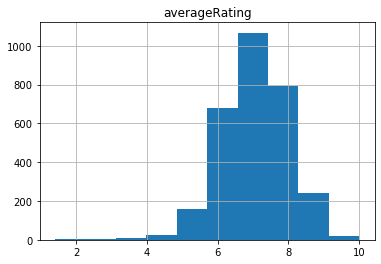

In [13]:
df.hist(column='averageRating')

We see that most of the titles are rated on average around 5.8 to 8.2, and very few has an average rating below 4.

Let us have a look at the number of votes next.

In [14]:
    print('Min number of votes', df['numVotes'].min())
print('Max number of votes', df['numVotes'].max())
print('Mean number of votes', df['numVotes'].mean())

Min number of votes 60283
Max number of votes 2160093
Mean number of votes 197832.647


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f665a657d30>]],
      dtype=object)

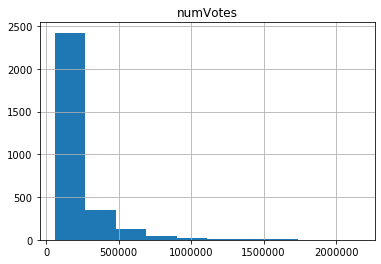

In [15]:
df.hist(column='numVotes')

From the min, max and mean of the number of votes we see that the column spans a wide interval of values, where the bulk of the data points have below 500 thousand votes. The most rated title is rated by a whopping 2.1 million users!

Let's have a look at the genres next!

In [16]:
ids_to_titles = dict()
ids_in_genres = defaultdict(list)
genres_counter = defaultdict(int)
ids_to_genres = dict()

for _, r in df.iterrows():
    ids_to_titles[r['tconst']] = r['primaryTitle']
    ids_to_genres[r['tconst']] = r['genres'].split(',')
    for g in ids_to_genres[r['tconst']]:
        ids_in_genres[g].append(r['tconst'])
        genres_counter[g] += 1

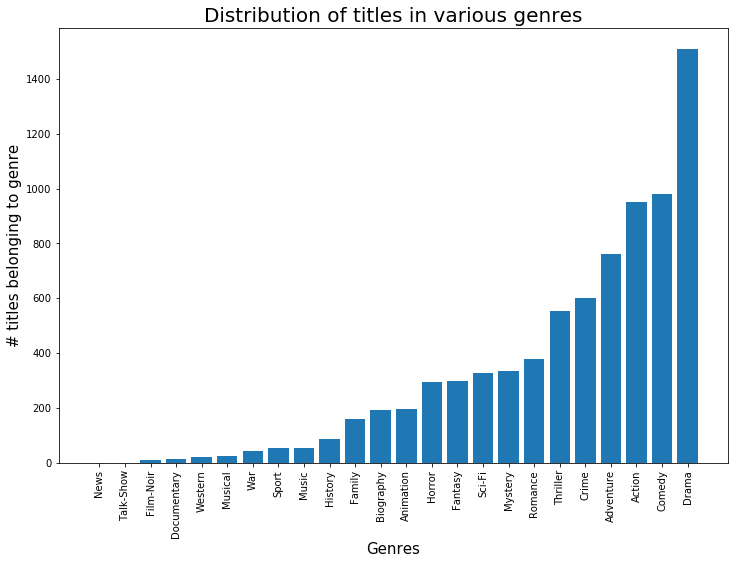

In [17]:
sorted_genres = sorted(genres_counter.items(), key=lambda item: item[1])
genres, counts = list(zip(*sorted_genres))
    
plt.figure(figsize=(12,8))
plt.bar(genres, counts)
plt.title("Distribution of titles in various genres", fontsize=20)
plt.xticks(rotation='vertical')
plt.xlabel("Genres", fontsize=15)
plt.ylabel("# titles belonging to genre", fontsize=15)

plt.show()

The 3 most dominant genres in the top 3000 rated movies are Drama, Comedy and Action where around half of the movies belong to the drama genre. It should be noted that a movie can be in more than one genre.

# Pre-processing of user reviews

Before working with the review text it is advised to process it a bit first. We start by lower casing the entire review text as the same word will be recognized as different words if the case differs. E.g. hello and HelLo will be two distinct words. In case someone included raw HTML sequences in the text we translate these into their proper symbols. From the text we remove all hyperlinks and remove punctuation by replacing it with whitespace.
The `clean()` method we constructed below is a modified version of the one we created for the second assignment. We opted to replace the `TweetTokenizer` class with the `split()` method from the Python standad library, as it should be a tad quicker at processing the text. As the last step we remove stopwords from the tokenized text as these stopwords usually account for a large part of the sentence and are usually meaningless for the context.

We return the length of the original text to use at a later stage when we compute statistics, along with the cleaned and tokenized version of the text.

# Part 3: Initializing the graph
We want to build a graph where our nodes correspond to movies. The label used will be the unique imdb id `tconst`. 
Our link criteria between two nodes requires that a user has reviewed both movies which creates a link with weight 1. Every time that scenario is fulfilled we increment the weight of the link.

Essentially what this means is that all the associated review titles to a user will be represented as a *complete* graph. For complete graphs the following equation is relevant

$\frac{n(n-1)}{2} = v$

where $v$ are the maximum number of edges. Which in our case of $n=$3000 approaches a maximum of almost 4.5 million links.

Only when a link is already in place between two nodes our total number of links does not increase, but then the weight of that existing link does. We expect to see significance of the added weights when exploring communities.

To prepare for this we build a dictionary of all the movies with keys as reviewers and values as the titles using `tconst`.

In [18]:
# dict holding maps of username to the titles reviewed
reviewed_ids = defaultdict(list)

# get all the files
files = list(os.walk(reviews_path))

# each file contains the user reviews for a single movie title
for f in files[0][2]:
    try:
        df = pd.read_csv(reviews_path+f, sep='\t')
        
        # map username to titles
        for _, row in df.iterrows():
            reviewed_ids[row['username']].append(row['tconst'])
    except:
        print("Problem reading file", f)

In regards to building the network we do not care about users who made single reviews, these users are interesting
for other analysis, but we want to prepare this graph for community detection based on the previously mentioned link
criteria.

In [19]:

# exclude reviewers who only wrote a single review to prepare data for our graph
graph_data = {k: v for k, v in reviewed_ids.items() if len(v) > 1 }

# number of single reviews
singles = len(reviewed_ids.keys())-len(graph_data.keys())
print(singles, "reviews were removed")
print(len(graph_data.keys()), "reviews will be used for the graph")

474970 reviews were removed
180035 reviews will be used for the graph


Using the dictionary we can now build our graph using the networkx library.

In [21]:
# initialize primary graph
G = nx.Graph()

# go through first 15 reviewers
for titles in list(graph_data.values()):
    # insert the titles of the reviewer as nodes
    G.add_nodes_from(titles) 
    
    # use combinations to establish all possible edges between titles
    edges = combinations(titles, 2)
    
    # either add a link between nodes 'u' and 'v' or increment weight of existing link
    for u,v in edges:
        if (G.has_edge(u,v) == False):
            G.add_edge(u,v, weight=1)
        else:
            G[u][v]['weight'] = G[u][v]['weight'] + 1
            
# inspect the graph dimensions
print(len(G.nodes()), "nodes were created.")
print(len(G.edges()), "edges were created.")

3000 nodes were created.
4414342 edges were created.


In [22]:
# used to plot the degree distribution of a graph

def plot_degree_dist(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.xlabel('Degree')
    plt.ylabel('# Nodes')
    plt.bar(deg, cnt, width=1, color="#2ECC71")

### Selecting a subgraph
Due to the size of the network $(V,E) = (3000,4414342)$ we would lik to be able to place a cutoff and inspect a narrower selection of the graph according to link weights. E.g. how would the top 20 percent of the network look like when using this setup. Therefore we define a function allowing us to create a graph based on link weights.

In [23]:
def graph_by_weight(G, weight):
    # initialize separate graph for a custom build 
    GC = nx.Graph()

    # filter all edges of input graph 'G' by weight parameter
    select_edges = [(u,v,w) for u,v,w in G.edges.data() if w['weight'] >= weight]

    # add the corresponding nodes to 'GC' with their selected edges
    GC.add_edges_from(select_edges)
    for u,v,_ in select_edges:
        GC.add_node(u)
        GC.add_node(v)
    
    # printing number of nodes and edges
    print("New graph dimensions:")
    print("Nodes V:", len(GC.nodes()), "\nEdges E:",(len(GC.edges())))
    return(GC)

G = graph_by_weight(G, 200)

New graph dimensions:
Nodes V: 328 
Edges E: 1256


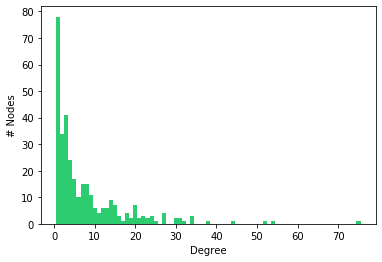

In [33]:
plot_degree_dist(G)

In [34]:

# NOTE: degree needs to take in account the weights of the edges
degree_list=list(map(lambda x : x[1], list(G.degree(weight='weight'))))
node_size=list(map(lambda x : x/sum(degree_list), degree_list))

pos_titles = nx.spring_layout(G, k=0.15, iterations=10)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.01,

                        # Performance
                        jitterTolerance=0.0001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.25,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.01,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=pos_titles,iterations=10000)

100%|██████████| 10000/10000 [00:38<00:00, 262.01it/s]

BarnesHut Approximation  took  4.32  seconds
Repulsion forces  took  30.94  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.90  seconds
AdjustSpeedAndApplyForces step  took  0.68  seconds


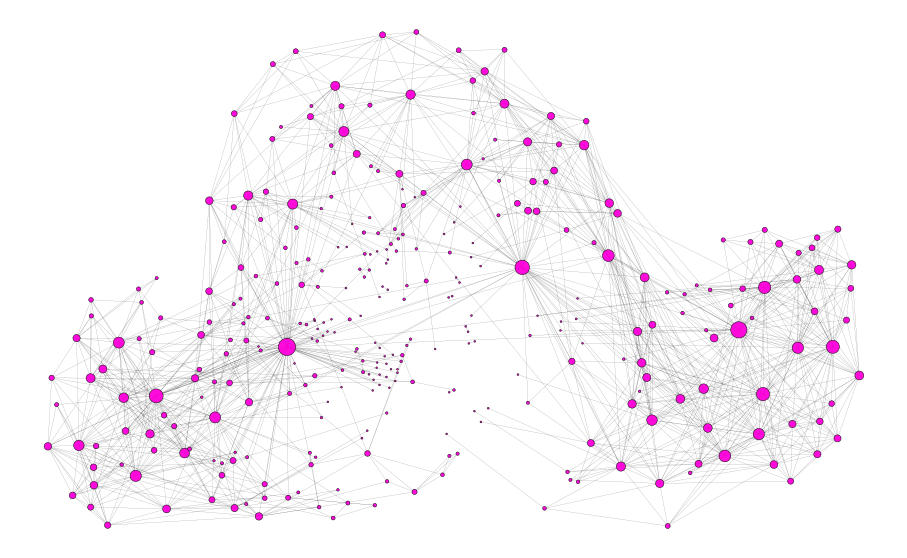

In [35]:
plt.figure(figsize=(16,10))
plt.axis("off")

nx.draw_networkx(G, positions, 
        node_size = [x*10000 for x in node_size],
        node_color = '#FF00DC',
        alpha = 0.95,
        edgecolors = '#000000',
        linewidths = 0.5,
        width = 0.1,
        with_labels = False)

# Part 4: Community detection
In the previous part we setup an example graph `GC` that we will now analyze for potential communites

In [40]:
from community import community_louvain

# partition the graph trying to maximize modularity using the Louvain heuristices
partition = community_louvain.best_partition(G)

# compute the modularity of the partition
modularity = community_louvain.modularity(partition, G, weight='weight')

# compute the number of communities and print it along the modularity value
partition_values = list(partition.values())
size = len(set(partition_values))
print("communities count:\n",size)
print("\nmodularity:\n",modularity)

# find the sizes of the different communities
community_sizes = [partition_values.count(i) for i in range(size)]
print("\nsize distribution:\n",community_sizes)

communities count:
 17

modularity:
 0.6319618866955762

size distribution:
 [38, 71, 48, 2, 64, 4, 2, 4, 27, 2, 47, 2, 2, 8, 3, 2, 2]


Our communities in the network are well partitioned, indicated by the modularity score. To give a better understanding of it all we need to see some nodes and links of these communites. We will visualize them using forceatlas as already defined.

In [41]:
# define colormap used to separate communities when plotting
colors=['#C0C0C0','#2ECC71','#F1C40F','#E74C3C','#E74C3C','#FFFF00',
        '#008080','#808080','#008000','#3498DB','#800080','#00FFFF',
        '#000080','#FF00FF','#808000','#33B5FF','#FFC300']

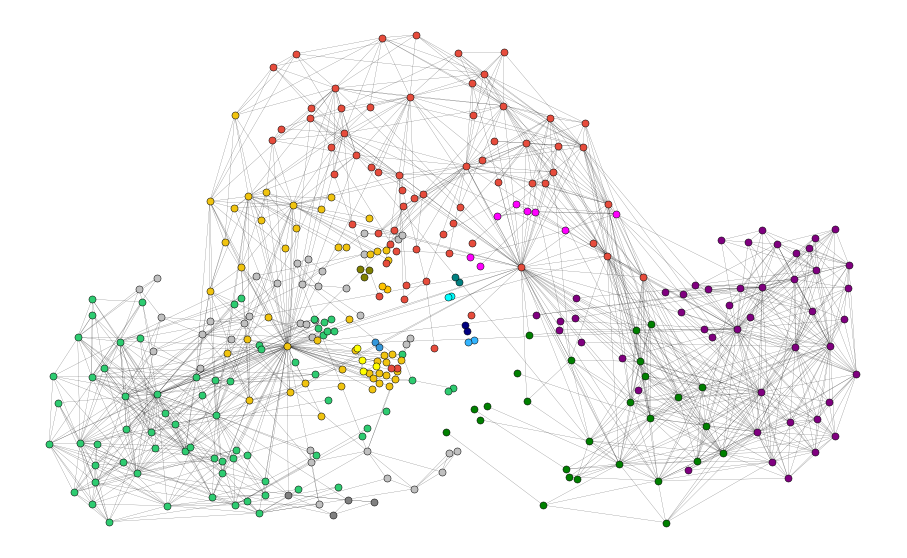

In [42]:
# get all the movies part of the communities
titles = list(partition.keys())

# plot using forceatlas positions
plt.figure(figsize=(16,10))
plt.axis("off")
pos = positions 

# initialize counter for color mapping
c = 0
for com in set(partition_values):
    # match title to a community and draw it using the color indexed by 'count'
    list_nodes = [titles[i] for i in range(len(titles)) if partition_values[i] == com]
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=list_nodes,
                           node_size = 50,
                           edgecolors = '#000000',
                           linewidths = 0.5,
                           node_color = colors[c])
    c += 1

nx.draw_networkx_edges(G,
                       pos,
                       list(G.edges),
                       width = 0.15,
                       arrows=False,
                       alpha=0.95)

plt.show()

The visualization does show that some communities are more dominant than others. The purple, red, green, blue and yellow are among the larger ones, but the remaining ones are quite hard to spot. Let us investigate if and how these top communites differ from one another.

In [43]:
# Load datasets
imdb_basic = 'title.basics.tsv'
imdb_ratings = 'title.ratings.tsv'

df = pd.read_csv(imdb_basic, sep='\t')
ratings = pd.read_csv(imdb_ratings, sep='\t')

# we are interested with the 3000 most rated titles
ratings = ratings.sort_values(by=['numVotes'], ascending=False)[:3000]

# for these we add a column to keep track of if we have fetched the user reviews or not
ratings.insert(3, "ReviewsFetched", len(ratings)*[False], True)
df = pd.merge(df, ratings, on='tconst')


tconst_to_genres = defaultdict(list)
for _, r in df.iterrows():
    for g in r['genres'].split(','):
        tconst_to_genres[r['tconst']].append(g)

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [44]:
# add communities to list of communities

communities = []
for com in set(partition_values):
    list_titles = [titles[i] for i in range(len(titles)) if partition_values[i] == com]
    communities.append(list_titles)

# sort communities by their size
communities.sort(key=len, reverse=True)

# dict containing maps between communites and genres
com_to_genres = defaultdict(list)

# find the genres of community titles by looking in 'tconst_to_genres'
for num, com in enumerate(communities):
    for title in com:
        com_to_genres[num].extend(tconst_to_genres[title])

# bag of words for communities
community_bows = defaultdict(lambda: defaultdict(int))

# generate BoW representation of all reviews grouped by title
for com, genres in com_to_genres.items(): 
    for w in genres:
        community_bows[com][w] += 1

# create a representation of all possible genres in the network
genres = list(com_to_genres.values())

unique_genres = []
for g in genres:
    unique_genres.extend(g)
    
unique_genres = list(set(unique_genres))
print("GC Genres:\n",unique_genres)

GC Genres:
 ['Music', 'Horror', 'Fantasy', 'Family', 'Mystery', 'Musical', 'Western', 'Drama', 'War', 'Comedy', 'Crime', 'Action', 'Biography', 'Animation', 'History', 'Thriller', 'Romance', 'Adventure', 'Sci-Fi']


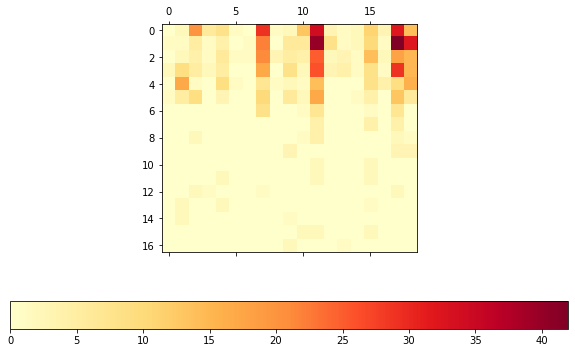

In [45]:
import numpy as np

# init matrix with communites as rows and genres as coloumns
D = [  [ 0 for i in range(len(unique_genres)) ] for j in range(len(communities)) ]

for com, bows in community_bows.items():
    for word, count in bows.items():
        D[com][unique_genres.index(word)] = count
        
# genereate heatmap
fig, ax = plt.subplots(figsize = (10,6))
cax = ax.matshow(D, cmap=plt.cm.YlOrRd)
fig.colorbar(cax, orientation = "horizontal")
plt.show()

# Part 5 - Sentiment analysis and word clouds

In [46]:
# Function used for cleaning a review
def clean(text):
    output = text
    output = output.lower()  # lower-case the text
    output = html.unescape(output)  # translate strings like &amp; to proper symbols
    output = re.sub(r"http\S+", " ", output) # remove URLs
    output = re.sub(r"[^'\w]", " ", output)  # replaces all symbols but ' with spaces
    output = re.sub(r'\d+', " ", output)  # replace numbers

    output = output.split()
    original_length = len(output)
    
    # Remove stopwords from the tokenized review
    output = [word for word in output if word not in stop_words]
    
    return original_length, output

We include a method for computing the sentiment of a text created during the second assignment. This method is used to compute the sentiment of each review, to get a gist about the distribution of the sentiment among the user reviews.

In [47]:
def h_avg(text):
    """ compute average happiness score based on the LabMT sentiment dataset """
    num_words, score = 0, 0
    
    for w in text:
        if w in labmt:
            score += float(labmt[w])
            num_words += 1
    
    if num_words > 0:
        return score / num_words
    
    return 0

In [48]:
counter = 0

reviewed_ids = defaultdict(list)  # maps a username to the titles he has reviewed
review_bows = defaultdict(lambda: defaultdict(int))  # map titleID to BoW of all reviews
review_lengths = defaultdict(list)
sentiments = defaultdict(list)

#positive_bows = defaultdict(lambda: defaultdict(int))
#negative_bows = defaultdict(lambda: defaultdict(int))

avg_rating = {}  # average rating of all reviews in a title

files = list(os.walk(reviews_path))  # locate all the files
for f in files[0][2]:  # each file contains the user reviews for a single movie title
    print(counter, '/ 3000. Working on', f)
    counter += 1  # keep track of how many we have processed
    
    try:
        df = pd.read_csv(reviews_path+f, sep='\t')
        avg_rating[f.split()[0]] = df['rating'].mean()
        for _, row in df.iterrows():
            # generate BoW representation of all reviews grouped by title
            length, cleaned_text = clean(row['text'])
            
            review_lengths[row['tconst']].append(length)
            sentiments[row['tconst']].append(h_avg(cleaned_text))
            
            for w in cleaned_text:
                review_bows[row['tconst']][w] += 1
                
            reviewed_ids[row['username']].append(row['tconst'])
    except FileNotFoundError:
        print("Problem processing file", f)

0 / 3000. Working on tt0032138.tsv
1 / 3000. Working on tt0435705.tsv
2 / 3000. Working on tt0816711.tsv
3 / 3000. Working on tt0097778.tsv
4 / 3000. Working on tt1588334.tsv
5 / 3000. Working on tt1232829.tsv
6 / 3000. Working on tt0367089.tsv
7 / 3000. Working on tt0099871.tsv
8 / 3000. Working on tt1790886.tsv
9 / 3000. Working on tt1655441.tsv
10 / 3000. Working on tt6565702.tsv
11 / 3000. Working on tt0171363.tsv
12 / 3000. Working on tt0120791.tsv
13 / 3000. Working on tt1661199.tsv
14 / 3000. Working on tt0268695.tsv
15 / 3000. Working on tt0381061.tsv
16 / 3000. Working on tt0424136.tsv
17 / 3000. Working on tt5114356.tsv
18 / 3000. Working on tt1241317.tsv
19 / 3000. Working on tt0325703.tsv
20 / 3000. Working on tt1103153.tsv
21 / 3000. Working on tt0386676.tsv
22 / 3000. Working on tt0454848.tsv
23 / 3000. Working on tt3195644.tsv
24 / 3000. Working on tt0137523.tsv
25 / 3000. Working on tt0080339.tsv
26 / 3000. Working on tt0080684.tsv
27 / 3000. Working on tt4530422.tsv
28

225 / 3000. Working on tt0257044.tsv
226 / 3000. Working on tt3385516.tsv
227 / 3000. Working on tt0878804.tsv
228 / 3000. Working on tt0328832.tsv
229 / 3000. Working on tt0300051.tsv
230 / 3000. Working on tt0949731.tsv
231 / 3000. Working on tt0067116.tsv
232 / 3000. Working on tt1220634.tsv
233 / 3000. Working on tt0499556.tsv
234 / 3000. Working on tt4046784.tsv
235 / 3000. Working on tt0445990.tsv
236 / 3000. Working on tt1172570.tsv
237 / 3000. Working on tt0089880.tsv
238 / 3000. Working on tt0079522.tsv
239 / 3000. Working on tt1204342.tsv
240 / 3000. Working on tt1588170.tsv
241 / 3000. Working on tt1142988.tsv
242 / 3000. Working on tt0357277.tsv
243 / 3000. Working on tt0110357.tsv
244 / 3000. Working on tt2357547.tsv
245 / 3000. Working on tt0206634.tsv
246 / 3000. Working on tt0425112.tsv
247 / 3000. Working on tt0129167.tsv
248 / 3000. Working on tt1386703.tsv
249 / 3000. Working on tt5057054.tsv
250 / 3000. Working on tt0248667.tsv
251 / 3000. Working on tt1187043.tsv
2

447 / 3000. Working on tt0114214.tsv
448 / 3000. Working on tt0265349.tsv
449 / 3000. Working on tt0277296.tsv
450 / 3000. Working on tt1939659.tsv
451 / 3000. Working on tt0307479.tsv
452 / 3000. Working on tt2080374.tsv
453 / 3000. Working on tt0120082.tsv
454 / 3000. Working on tt0055928.tsv
455 / 3000. Working on tt1854564.tsv
456 / 3000. Working on tt1396218.tsv
457 / 3000. Working on tt0418689.tsv
458 / 3000. Working on tt0286106.tsv
459 / 3000. Working on tt1446714.tsv
460 / 3000. Working on tt0770703.tsv
461 / 3000. Working on tt0087277.tsv
462 / 3000. Working on tt0389722.tsv
463 / 3000. Working on tt1100089.tsv
464 / 3000. Working on tt1242460.tsv
465 / 3000. Working on tt0245574.tsv
466 / 3000. Working on tt2277860.tsv
467 / 3000. Working on tt0052357.tsv
468 / 3000. Working on tt1667889.tsv
469 / 3000. Working on tt0462465.tsv
470 / 3000. Working on tt5555260.tsv
471 / 3000. Working on tt0387131.tsv
472 / 3000. Working on tt4178092.tsv
473 / 3000. Working on tt1596343.tsv
4

669 / 3000. Working on tt0044741.tsv
670 / 3000. Working on tt1583421.tsv
671 / 3000. Working on tt1981677.tsv
672 / 3000. Working on tt1038919.tsv
673 / 3000. Working on tt0450385.tsv
674 / 3000. Working on tt0078346.tsv
675 / 3000. Working on tt0416236.tsv
676 / 3000. Working on tt1600196.tsv
677 / 3000. Working on tt0120647.tsv
678 / 3000. Working on tt0056923.tsv
679 / 3000. Working on tt0117802.tsv
680 / 3000. Working on tt0773262.tsv
681 / 3000. Working on tt1321511.tsv
682 / 3000. Working on tt1591095.tsv
683 / 3000. Working on tt0120737.tsv
684 / 3000. Working on tt0338751.tsv
685 / 3000. Working on tt0421715.tsv
686 / 3000. Working on tt0473705.tsv
687 / 3000. Working on tt0758746.tsv
688 / 3000. Working on tt0397442.tsv
689 / 3000. Working on tt0114148.tsv
690 / 3000. Working on tt2283336.tsv
691 / 3000. Working on tt1600194.tsv
692 / 3000. Working on tt0377471.tsv
693 / 3000. Working on tt1648179.tsv
694 / 3000. Working on tt4651520.tsv
695 / 3000. Working on tt0146838.tsv
6

891 / 3000. Working on tt1504320.tsv
892 / 3000. Working on tt3397884.tsv
893 / 3000. Working on tt0097733.tsv
894 / 3000. Working on tt1636826.tsv
895 / 3000. Working on tt1517260.tsv
896 / 3000. Working on tt1325004.tsv
897 / 3000. Working on tt0116908.tsv
898 / 3000. Working on tt3967856.tsv
899 / 3000. Working on tt3045616.tsv
900 / 3000. Working on tt0213847.tsv
901 / 3000. Working on tt1474684.tsv
902 / 3000. Working on tt7767422.tsv
903 / 3000. Working on tt0098635.tsv
904 / 3000. Working on tt0119345.tsv
905 / 3000. Working on tt4698684.tsv
906 / 3000. Working on tt1127180.tsv
907 / 3000. Working on tt1182345.tsv
908 / 3000. Working on tt1385867.tsv
909 / 3000. Working on tt0384766.tsv
910 / 3000. Working on tt0468492.tsv
911 / 3000. Working on tt0299977.tsv
912 / 3000. Working on tt3065204.tsv
913 / 3000. Working on tt1687901.tsv
914 / 3000. Working on tt1637725.tsv
915 / 3000. Working on tt3882082.tsv
916 / 3000. Working on tt0221027.tsv
917 / 3000. Working on tt0056869.tsv
9

1110 / 3000. Working on tt1205489.tsv
1111 / 3000. Working on tt0276919.tsv
1112 / 3000. Working on tt0456554.tsv
1113 / 3000. Working on tt0903747.tsv
1114 / 3000. Working on tt0401445.tsv
1115 / 3000. Working on tt0488120.tsv
1116 / 3000. Working on tt0063442.tsv
1117 / 3000. Working on tt1951265.tsv
1118 / 3000. Working on tt0076752.tsv
1119 / 3000. Working on tt0106489.tsv
1120 / 3000. Working on tt1292566.tsv
1121 / 3000. Working on tt0090264.tsv
1122 / 3000. Working on tt1821694.tsv
1123 / 3000. Working on tt0080487.tsv
1124 / 3000. Working on tt0435625.tsv
1125 / 3000. Working on tt0057012.tsv
1126 / 3000. Working on tt0120902.tsv
1127 / 3000. Working on tt1645170.tsv
1128 / 3000. Working on tt1915581.tsv
1129 / 3000. Working on tt0116695.tsv
1130 / 3000. Working on tt0859163.tsv
1131 / 3000. Working on tt2234222.tsv
1132 / 3000. Working on tt0104714.tsv
1133 / 3000. Working on tt0102685.tsv
1134 / 3000. Working on tt2024432.tsv
1135 / 3000. Working on tt0129387.tsv
1136 / 3000.

1326 / 3000. Working on tt2935510.tsv
1327 / 3000. Working on tt1601913.tsv
1328 / 3000. Working on tt1663202.tsv
1329 / 3000. Working on tt6763664.tsv
1330 / 3000. Working on tt0203019.tsv
1331 / 3000. Working on tt0079116.tsv
1332 / 3000. Working on tt0056172.tsv
1333 / 3000. Working on tt1586752.tsv
1334 / 3000. Working on tt2170593.tsv
1335 / 3000. Working on tt1318514.tsv
1336 / 3000. Working on tt4701182.tsv
1337 / 3000. Working on tt0386117.tsv
1338 / 3000. Working on tt1666801.tsv
1339 / 3000. Working on tt1956620.tsv
1340 / 3000. Working on tt0182789.tsv
1341 / 3000. Working on tt0433383.tsv
1342 / 3000. Working on tt0065214.tsv
1343 / 3000. Working on tt1234719.tsv
1344 / 3000. Working on tt0082495.tsv
1345 / 3000. Working on tt6155172.tsv
1346 / 3000. Working on tt0183649.tsv
1347 / 3000. Working on tt2312718.tsv
1348 / 3000. Working on tt3501632.tsv
1349 / 3000. Working on tt0093822.tsv
1350 / 3000. Working on tt3416742.tsv
1351 / 3000. Working on tt2119532.tsv
1352 / 3000.

1542 / 3000. Working on tt1196946.tsv
1543 / 3000. Working on tt1700841.tsv
1544 / 3000. Working on tt0209163.tsv
1545 / 3000. Working on tt1172049.tsv
1546 / 3000. Working on tt0322259.tsv
1547 / 3000. Working on tt0032551.tsv
1548 / 3000. Working on tt0075029.tsv
1549 / 3000. Working on tt2798920.tsv
1550 / 3000. Working on tt1667353.tsv
1551 / 3000. Working on tt1637727.tsv
1552 / 3000. Working on tt0408306.tsv
1553 / 3000. Working on tt0025316.tsv
1554 / 3000. Working on tt0070328.tsv
1555 / 3000. Working on tt0936501.tsv
1556 / 3000. Working on tt1272878.tsv
1557 / 3000. Working on tt0373051.tsv
1558 / 3000. Working on tt0185183.tsv
1559 / 3000. Working on tt0478304.tsv
1560 / 3000. Working on tt0162346.tsv
1561 / 3000. Working on tt0480687.tsv
1562 / 3000. Working on tt0472954.tsv
1563 / 3000. Working on tt0333766.tsv
1564 / 3000. Working on tt0105665.tsv
1565 / 3000. Working on tt1837492.tsv
1566 / 3000. Working on tt0322330.tsv
1567 / 3000. Working on tt0120863.tsv
1568 / 3000.

1758 / 3000. Working on tt0120363.tsv
1759 / 3000. Working on tt0339291.tsv
1760 / 3000. Working on tt0091167.tsv
1761 / 3000. Working on tt2071645.tsv
1762 / 3000. Working on tt0053198.tsv
1763 / 3000. Working on tt0315983.tsv
1764 / 3000. Working on tt0478087.tsv
1765 / 3000. Working on tt0436697.tsv
1766 / 3000. Working on tt1798684.tsv
1767 / 3000. Working on tt0096061.tsv
1768 / 3000. Working on tt0350258.tsv
1769 / 3000. Working on tt0449010.tsv
1770 / 3000. Working on tt0092991.tsv
1771 / 3000. Working on tt1641349.tsv
1772 / 3000. Working on tt0250494.tsv
1773 / 3000. Working on tt0200465.tsv
1774 / 3000. Working on tt0455824.tsv
1775 / 3000. Working on tt2406566.tsv
1776 / 3000. Working on tt0765429.tsv
1777 / 3000. Working on tt0086879.tsv
1778 / 3000. Working on tt0082010.tsv
1779 / 3000. Working on tt0780504.tsv
1780 / 3000. Working on tt0268978.tsv
1781 / 3000. Working on tt2172934.tsv
1782 / 3000. Working on tt0073195.tsv
1783 / 3000. Working on tt0164184.tsv
1784 / 3000.

1974 / 3000. Working on tt2568862.tsv
1975 / 3000. Working on tt8772262.tsv
1976 / 3000. Working on tt4630562.tsv
1977 / 3000. Working on tt1126618.tsv
1978 / 3000. Working on tt2704998.tsv
1979 / 3000. Working on tt0314353.tsv
1980 / 3000. Working on tt0061722.tsv
1981 / 3000. Working on tt0088939.tsv
1982 / 3000. Working on tt5074352.tsv
1983 / 3000. Working on tt1646971.tsv
1984 / 3000. Working on tt0402022.tsv
1985 / 3000. Working on tt0399295.tsv
1986 / 3000. Working on tt1355631.tsv
1987 / 3000. Working on tt5104604.tsv
1988 / 3000. Working on tt1605717.tsv
1989 / 3000. Working on tt0075148.tsv
1990 / 3000. Working on tt0075686.tsv
1991 / 3000. Working on tt0465602.tsv
1992 / 3000. Working on tt0103874.tsv
1993 / 3000. Working on tt0365686.tsv
1994 / 3000. Working on tt0372784.tsv
1995 / 3000. Working on tt0093894.tsv
1996 / 3000. Working on tt6751668.tsv
1997 / 3000. Working on tt1284575.tsv
1998 / 3000. Working on tt0379725.tsv
1999 / 3000. Working on tt0173840.tsv
2000 / 3000.

2191 / 3000. Working on tt0241527.tsv
2192 / 3000. Working on tt0329774.tsv
2193 / 3000. Working on tt0870111.tsv
2194 / 3000. Working on tt1578873.tsv
2195 / 3000. Working on tt2582846.tsv
2196 / 3000. Working on tt0401383.tsv
2197 / 3000. Working on tt1034314.tsv
2198 / 3000. Working on tt5742374.tsv
2199 / 3000. Working on tt0805564.tsv
2200 / 3000. Working on tt1542344.tsv
2201 / 3000. Working on tt0250258.tsv
2202 / 3000. Working on tt0272020.tsv
2203 / 3000. Working on tt1212428.tsv
2204 / 3000. Working on tt0249462.tsv
2205 / 3000. Working on tt0051201.tsv
2206 / 3000. Working on tt1219024.tsv
2207 / 3000. Working on tt0790636.tsv
2208 / 3000. Working on tt0450278.tsv
2209 / 3000. Working on tt2679042.tsv
2210 / 3000. Working on tt1398426.tsv
2211 / 3000. Working on tt0491738.tsv
2212 / 3000. Working on tt0116365.tsv
2213 / 3000. Working on tt1067106.tsv
2214 / 3000. Working on tt0110413.tsv
2215 / 3000. Working on tt0120179.tsv
2216 / 3000. Working on tt0479884.tsv
2217 / 3000.

2407 / 3000. Working on tt0094012.tsv
2408 / 3000. Working on tt0258000.tsv
2409 / 3000. Working on tt0892791.tsv
2410 / 3000. Working on tt0083131.tsv
2411 / 3000. Working on tt1219342.tsv
2412 / 3000. Working on tt1840417.tsv
2413 / 3000. Working on tt1649419.tsv
2414 / 3000. Working on tt0349205.tsv
2415 / 3000. Working on tt1220719.tsv
2416 / 3000. Working on tt0453451.tsv
2417 / 3000. Working on tt0362359.tsv
2418 / 3000. Working on tt0934814.tsv
2419 / 3000. Working on tt1213663.tsv
2420 / 3000. Working on tt0816442.tsv
2421 / 3000. Working on tt1490017.tsv
2422 / 3000. Working on tt0295178.tsv
2423 / 3000. Working on tt0317740.tsv
2424 / 3000. Working on tt0821640.tsv
2425 / 3000. Working on tt1034032.tsv
2426 / 3000. Working on tt0096928.tsv
2427 / 3000. Working on tt1972571.tsv
2428 / 3000. Working on tt0107207.tsv
2429 / 3000. Working on tt3741834.tsv
2430 / 3000. Working on tt0910970.tsv
2431 / 3000. Working on tt0840196.tsv
2432 / 3000. Working on tt0068473.tsv
2433 / 3000.

2623 / 3000. Working on tt0205000.tsv
2624 / 3000. Working on tt0397535.tsv
2625 / 3000. Working on tt2057392.tsv
2626 / 3000. Working on tt0369339.tsv
2627 / 3000. Working on tt0138524.tsv
2628 / 3000. Working on tt0483607.tsv
2629 / 3000. Working on tt1454029.tsv
2630 / 3000. Working on tt0142688.tsv
2631 / 3000. Working on tt0385880.tsv
2632 / 3000. Working on tt0870984.tsv
2633 / 3000. Working on tt0304415.tsv
2634 / 3000. Working on tt1598778.tsv
2635 / 3000. Working on tt0295701.tsv
2636 / 3000. Working on tt0106856.tsv
2637 / 3000. Working on tt0090728.tsv
2638 / 3000. Working on tt1655442.tsv
2639 / 3000. Working on tt1355683.tsv
2640 / 3000. Working on tt1093908.tsv
2641 / 3000. Working on tt1614989.tsv
2642 / 3000. Working on tt0040522.tsv
2643 / 3000. Working on tt0963794.tsv
2644 / 3000. Working on tt1568346.tsv
2645 / 3000. Working on tt0800080.tsv
2646 / 3000. Working on tt1152836.tsv
2647 / 3000. Working on tt2004420.tsv
2648 / 3000. Working on tt0376541.tsv
2649 / 3000.

2839 / 3000. Working on tt2395695.tsv
2840 / 3000. Working on tt0345950.tsv
2841 / 3000. Working on tt0431308.tsv
2842 / 3000. Working on tt2543164.tsv
2843 / 3000. Working on tt0077766.tsv
2844 / 3000. Working on tt0365830.tsv
2845 / 3000. Working on tt0101507.tsv
2846 / 3000. Working on tt0113481.tsv
2847 / 3000. Working on tt0371246.tsv
2848 / 3000. Working on tt0420294.tsv
2849 / 3000. Working on tt1623205.tsv
2850 / 3000. Working on tt1403981.tsv
2851 / 3000. Working on tt0455590.tsv
2852 / 3000. Working on tt1843230.tsv
2853 / 3000. Working on tt0095031.tsv
2854 / 3000. Working on tt0150377.tsv
2855 / 3000. Working on tt0284837.tsv
2856 / 3000. Working on tt0758752.tsv
2857 / 3000. Working on tt2140379.tsv
2858 / 3000. Working on tt0256380.tsv
2859 / 3000. Working on tt0397306.tsv
2860 / 3000. Working on tt3682448.tsv
2861 / 3000. Working on tt0066921.tsv
2862 / 3000. Working on tt4501244.tsv
2863 / 3000. Working on tt1675192.tsv
2864 / 3000. Working on tt0364970.tsv
2865 / 3000.

In [ ]:
# WARNING: the below statements will overwrite the review BoWs saved to file. Use with caution
#with open('reviews-BoWs.json', 'w') as f:
#    json.dump(review_bows, f)

In [49]:
data = json.load(open('reviews-BoWs.json'))

In [50]:
total_length = sum(sum(l) for l in review_lengths.values())
num_reviews = sum(len(l) for l in review_lengths.values())
print('The', num_reviews, 'user reviews consist of', total_length, 'words in total')
print('A review consists of', math.floor(total_length/num_reviews), 'words on average')

The 1654524 user reviews consist of 381651416 words in total
A review consists of 230 words on average


In [51]:
# pick 4 random movie titles and generate word clouds for them
samples = random.choices(list(df['tconst']), k=4)
print('Picked samples', samples)

Picked samples ['tt0113855', 'tt0113855', 'tt0113855', 'tt0113855']


In [52]:
clouds = []

for s in samples:
    clouds.append(WordCloud(width=600, height=600, background_color='white').generate_from_frequencies(data[s]))

We generate word clouds for 4 movies selected at random for the set, to get an idea of how they might look for a single movie title.

(-0.5, 599.5, 599.5, -0.5)

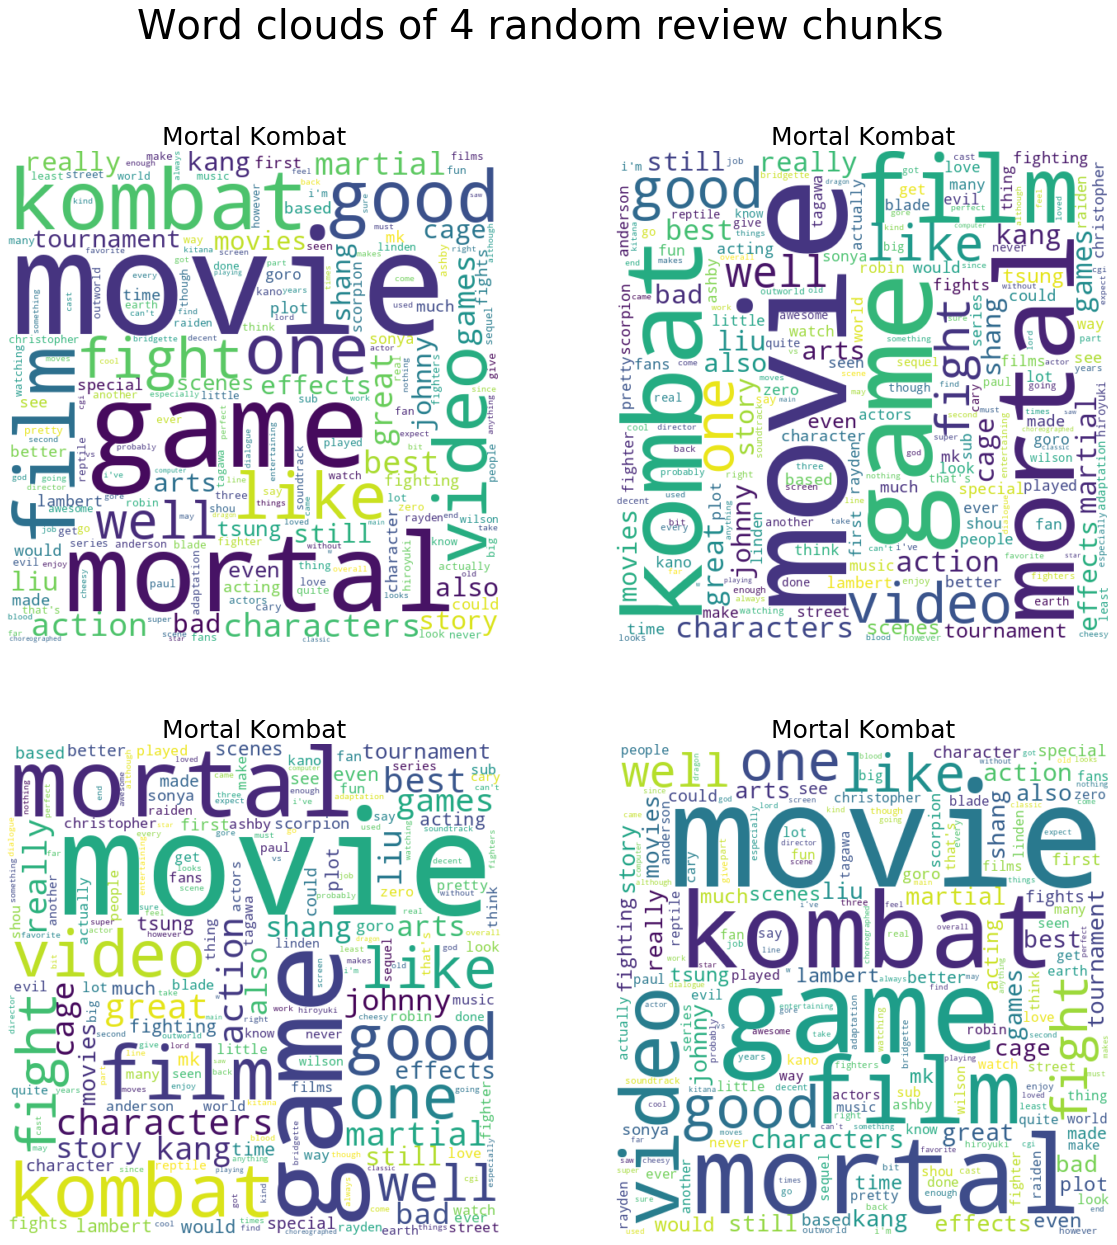

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

fig.suptitle('Word clouds of 4 random review chunks', fontsize=40)

# Plot the word clouds for the 4 titles selected at random
ax[0][0].set_title(ids_to_titles[samples[0]], fontsize=25)
ax[0][0].imshow(clouds[0], interpolation="bilinear")
ax[0][0].axis("off")

ax[0][1].set_title(ids_to_titles[samples[1]], fontsize=25)
ax[0][1].imshow(clouds[1], interpolation="bilinear")
ax[0][1].axis("off")

ax[1][0].set_title(ids_to_titles[samples[2]], fontsize=25)
ax[1][0].imshow(clouds[2], interpolation="bilinear")
ax[1][0].axis("off")

ax[1][1].set_title(ids_to_titles[samples[3]], fontsize=25)
ax[1][1].imshow(clouds[3], interpolation="bilinear")
ax[1][1].axis("off")

Let's have a look at how things are when we group stuff by their genre. A movie that belongs to multiple genres will be included in every genre it is a member of.

In [54]:
# Make combination BoWs where each title is added to its respective genres

genre_bows = defaultdict(lambda: defaultdict(int))

for genre, ids in ids_in_genres.items():
    print('Creating joint BoW for genre', genre)
    # go through all titles related to the genre
    for title_id in ids:
        # loop over BoW for the title and add to the genre dict
        for word, count in data[title_id].items():
            # add every single word and its count to the genre BoW
            genre_bows[genre][word] += count

Creating joint BoW for genre Comedy
Creating joint BoW for genre Drama
Creating joint BoW for genre Family
Creating joint BoW for genre Fantasy
Creating joint BoW for genre Horror
Creating joint BoW for genre Adventure
Creating joint BoW for genre Sci-Fi
Creating joint BoW for genre Action
Creating joint BoW for genre Romance
Creating joint BoW for genre Crime
Creating joint BoW for genre Mystery
Creating joint BoW for genre Thriller
Creating joint BoW for genre Animation
Creating joint BoW for genre History
Creating joint BoW for genre War
Creating joint BoW for genre Film-Noir
Creating joint BoW for genre Western
Creating joint BoW for genre Musical
Creating joint BoW for genre Music
Creating joint BoW for genre Biography
Creating joint BoW for genre Sport
Creating joint BoW for genre Documentary
Creating joint BoW for genre News
Creating joint BoW for genre Talk-Show


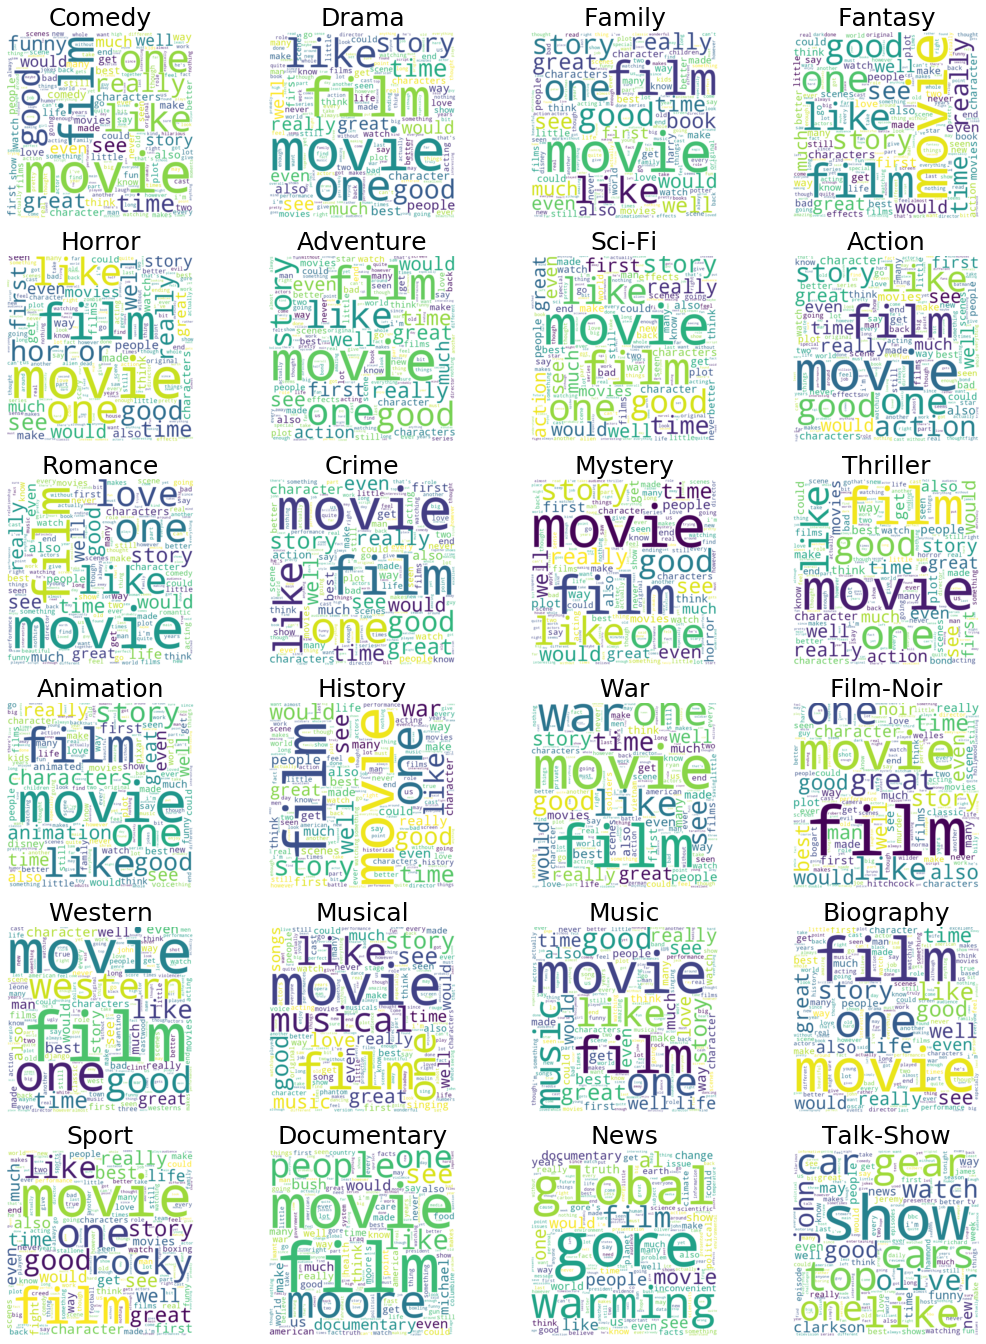

In [55]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(18, 24))

# create a word cloud for each genre and plot it in a 4x6 grid
for i, genre in enumerate(genres_counter.keys()):
    x, y = i % 4, math.floor(i/4)
    cloud = WordCloud(width=600, height=600, background_color='white').generate_from_frequencies(genre_bows[genre])
    ax[y][x].set_title(genre, fontsize=25)
    ax[y][x].imshow(cloud, interpolation="bilinear")
    ax[y][x].axis("off")

From the word clouds per genre shown above, it is clear that the words 'movie', 'film' and 'one' clearly appears in many reviews. It will be interesting to see how the clouds look when these words have been scaled down from passing the reviews through TF-IDF statistic. We think that after TF-IDF the genres will be easily identifiable from the word clouds.

## TF-IDF analysis by genre
To get a better picture of the words that help indentify a certain genre, we do a TF-IDF analysis on the set of reviews for each genre. The BoW reprentation we chose to store the reviews in already gives us the raw term frequencies for each genre.

In [56]:
adjusted_bows = defaultdict(lambda: defaultdict(float))

print(list(genre_bows['Action'].values())[:10])

for genre, bow in genre_bows.items():
    try:
        max_count = max(list(bow.values()))
        num_words = sum(list(bow.values()))
        for term, count in bow.items():
            # use double normalization 0.5 from wikipedia, did not work so well for us
            # adjusted_bows[genre][term] = 0.5 + 0.5 * (count/max_count)
            
            # adjust by total number of words in the BoW
            adjusted_bows[genre][term] = (count/num_words)
    except:
        print(genre, 'causes problems')

# Extract the 10 most popular terms
action_top10 = sorted(adjusted_bows['Action'].items(), key=lambda x: x[1], reverse=True)[:10]
comedy_top10 = sorted(adjusted_bows['Comedy'].items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 terms in the Action genre")
for term, count in action_top10:
    print(term + ":", count)
    
print()

print("Top 10 terms in the Comedy genre")
for term, count in comedy_top10:
    print(term + ":", count)

[66990, 1105, 721, 212802, 910191, 2226, 102715, 303393, 2389, 47947]
Top 10 terms in the Action genre
movie: 0.01888848627321604
film: 0.011859455077276801
one: 0.008234858621311033
like: 0.007592354367461461
good: 0.0063426691959791075
action: 0.0054260996326555445
story: 0.004776676643456981
really: 0.004626223466291622
time: 0.0043977618738072185
great: 0.004370725384449106

Top 10 terms in the Comedy genre
movie: 0.018294103976480725
film: 0.012303667870413976
one: 0.008366594508063156
like: 0.007399035471720343
good: 0.005732897054904842
really: 0.004676673332073361
time: 0.004478645496630504
great: 0.004346175336851168
funny: 0.004171028710824741
see: 0.004162975127247248


We tried a couple of different approaches regarding the term frequency measure. First we gave the raw count a go, but due to words like *movie*, *film* and so on accounting for a very large portion of the review texts, they ended up dominating the word clouds. We adjusted by the [double normalization 0.5 formula](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) found at the Wikipedia page for the TF-IDF topic, but the result ended up as gibberish, as the remainder of the words seemed to be mostly unique for each genre. After 

The top 10 of the two example genres have many terms in common and they confirm the need for the TF-IDF analysis.

In [57]:
# start off with an empty IDF dict
idf_dict = defaultdict(float)

# count how many documents the term exists in
for genre, bow in adjusted_bows.items():
    for term in bow.keys():
        idf_dict[term] += 1

# compute idf
for term, count in idf_dict.items():
    idf_dict[term] = math.log(len(adjusted_bows) / float(count))
    
print(sorted(idf_dict.items(), key=lambda x: x[1], reverse=True)[:10])
print(idf_dict['movie'])

[("'rehearsal'", 3.1780538303479458), ('sadesky', 3.1780538303479458), ('zogg', 3.1780538303479458), ('coulardeauto', 3.1780538303479458), ("heyden's", 3.1780538303479458), ('burpelson', 3.1780538303479458), ('mtsu', 3.1780538303479458), ('standly', 3.1780538303479458), ('bushesque', 3.1780538303479458), ('putta', 3.1780538303479458)]
0.0


The IDF dictionary effectively gives us a means of scaling the weight of a term in the word clouds to reveal which terms helps to identify a genre.

In [58]:
# Compute tf-idf for the two documents
tfidf = defaultdict(lambda: defaultdict(float))
for genre, bow in adjusted_bows.items():
    for term, count in bow.items():
        tfidf[genre][term] = count * idf_dict[term]

Let us inspect the IDF and TF-IDF top 10's to gain insight into the need of further adjustments.

In [59]:
idf_top10 = sorted(idf_dict.items(), key=lambda x: x[1], reverse=False)[:10]
tfidf_comedy_top10 = sorted(tfidf['Comedy'].items(), key=lambda x: x[1], reverse=True)[:10]

print("Bottom 10 IDF terms overall")
for term, count in idf_top10:
    print(term + ":", count)
    
print("\n Top 10 TF-IDF terms in the Comedy genre")
for term, count in tfidf_comedy_top10:
    print(term + ":", count)

Bottom 10 IDF terms overall
perhaps: 0.0
later: 0.0
features: 0.0
kid: 0.0
excellent: 0.0
achievement: 0.0
thoroughly: 0.0
enjoyable: 0.0
film: 0.0
young: 0.0

 Top 10 TF-IDF terms in the Comedy genre
plot: 8.577477534483136e-05
scene: 7.351452424923377e-05
performances: 5.62501955601218e-05
disney: 5.1661461479034516e-05
stiller: 5.144352077836029e-05
comedies: 4.805727500525949e-05
pixar: 4.6239117745817025e-05
moments: 4.541589094661661e-05
ferrell: 4.380055039041659e-05
played: 4.1740591846194486e-05


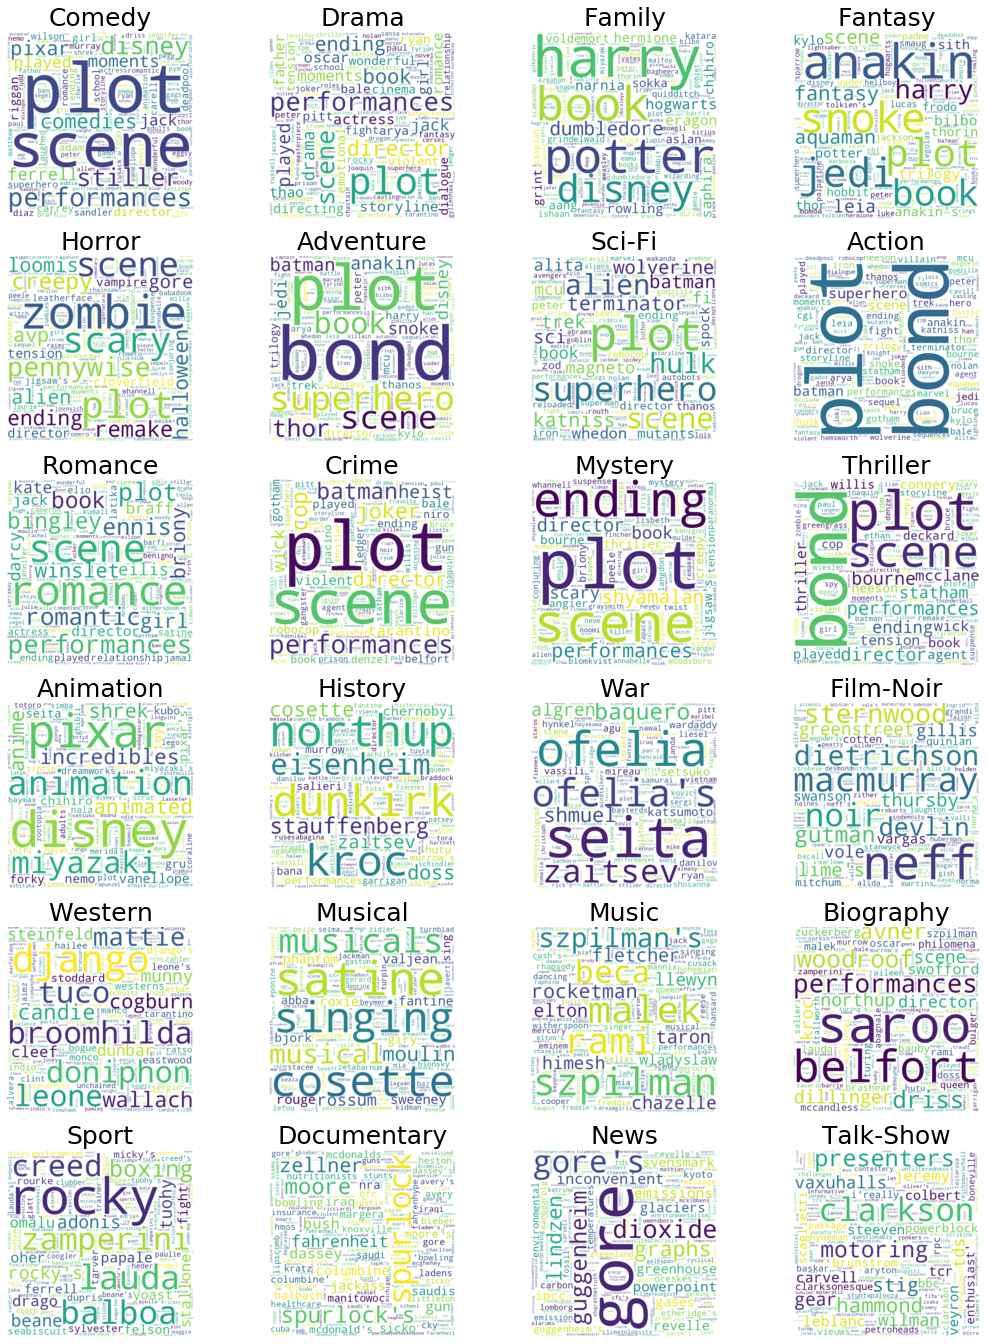

In [60]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(18, 24))

for i, genre in enumerate(tfidf.keys()):
    x, y = i % 4, math.floor(i/4)
    cloud = WordCloud(width=600, height=600, background_color='white').generate_from_frequencies(tfidf[genre])
    ax[y][x].set_title(genre, fontsize=25)
    ax[y][x].imshow(cloud, interpolation="bilinear")
    ax[y][x].axis("off")

In [61]:
# compute sentiment of each genre
# check avg rating vs. user review ratings distribution for each genre

ratings_dict = defaultdict(list)
counter = 0
# run through the review files again to find the user review ratings
files = list(os.walk(reviews_path))  # locate all the files
for f in files[0][2]:  # each file contains the user reviews for a single movie title
    print(counter, '/ 3000. Working on', f)
    counter += 1  # keep track of how many we have processed
    
    try:
        df = pd.read_csv(reviews_path+f, sep='\t')
        for _, row in df.iterrows():
            for g in ids_to_genres[row['tconst']]:
                ratings_dict[g].append(row['rating'])
    except FileNotFoundError:
        print("Problem processing file", f)

0 / 3000. Working on tt0032138.tsv
1 / 3000. Working on tt0435705.tsv
2 / 3000. Working on tt0816711.tsv
3 / 3000. Working on tt0097778.tsv
4 / 3000. Working on tt1588334.tsv
5 / 3000. Working on tt1232829.tsv
6 / 3000. Working on tt0367089.tsv
7 / 3000. Working on tt0099871.tsv
8 / 3000. Working on tt1790886.tsv
9 / 3000. Working on tt1655441.tsv
10 / 3000. Working on tt6565702.tsv
11 / 3000. Working on tt0171363.tsv
12 / 3000. Working on tt0120791.tsv
13 / 3000. Working on tt1661199.tsv
14 / 3000. Working on tt0268695.tsv
15 / 3000. Working on tt0381061.tsv
16 / 3000. Working on tt0424136.tsv
17 / 3000. Working on tt5114356.tsv
18 / 3000. Working on tt1241317.tsv
19 / 3000. Working on tt0325703.tsv
20 / 3000. Working on tt1103153.tsv
21 / 3000. Working on tt0386676.tsv
22 / 3000. Working on tt0454848.tsv
23 / 3000. Working on tt3195644.tsv
24 / 3000. Working on tt0137523.tsv
25 / 3000. Working on tt0080339.tsv
26 / 3000. Working on tt0080684.tsv
27 / 3000. Working on tt4530422.tsv
28

227 / 3000. Working on tt0878804.tsv
228 / 3000. Working on tt0328832.tsv
229 / 3000. Working on tt0300051.tsv
230 / 3000. Working on tt0949731.tsv
231 / 3000. Working on tt0067116.tsv
232 / 3000. Working on tt1220634.tsv
233 / 3000. Working on tt0499556.tsv
234 / 3000. Working on tt4046784.tsv
235 / 3000. Working on tt0445990.tsv
236 / 3000. Working on tt1172570.tsv
237 / 3000. Working on tt0089880.tsv
238 / 3000. Working on tt0079522.tsv
239 / 3000. Working on tt1204342.tsv
240 / 3000. Working on tt1588170.tsv
241 / 3000. Working on tt1142988.tsv
242 / 3000. Working on tt0357277.tsv
243 / 3000. Working on tt0110357.tsv
244 / 3000. Working on tt2357547.tsv
245 / 3000. Working on tt0206634.tsv
246 / 3000. Working on tt0425112.tsv
247 / 3000. Working on tt0129167.tsv
248 / 3000. Working on tt1386703.tsv
249 / 3000. Working on tt5057054.tsv
250 / 3000. Working on tt0248667.tsv
251 / 3000. Working on tt1187043.tsv
252 / 3000. Working on tt0165798.tsv
253 / 3000. Working on tt1086772.tsv
2

452 / 3000. Working on tt2080374.tsv
453 / 3000. Working on tt0120082.tsv
454 / 3000. Working on tt0055928.tsv
455 / 3000. Working on tt1854564.tsv
456 / 3000. Working on tt1396218.tsv
457 / 3000. Working on tt0418689.tsv
458 / 3000. Working on tt0286106.tsv
459 / 3000. Working on tt1446714.tsv
460 / 3000. Working on tt0770703.tsv
461 / 3000. Working on tt0087277.tsv
462 / 3000. Working on tt0389722.tsv
463 / 3000. Working on tt1100089.tsv
464 / 3000. Working on tt1242460.tsv
465 / 3000. Working on tt0245574.tsv
466 / 3000. Working on tt2277860.tsv
467 / 3000. Working on tt0052357.tsv
468 / 3000. Working on tt1667889.tsv
469 / 3000. Working on tt0462465.tsv
470 / 3000. Working on tt5555260.tsv
471 / 3000. Working on tt0387131.tsv
472 / 3000. Working on tt4178092.tsv
473 / 3000. Working on tt1596343.tsv
474 / 3000. Working on tt0117008.tsv
475 / 3000. Working on tt1164999.tsv
476 / 3000. Working on tt1790809.tsv
477 / 3000. Working on tt0383574.tsv
478 / 3000. Working on tt0091369.tsv
4

675 / 3000. Working on tt0416236.tsv
676 / 3000. Working on tt1600196.tsv
677 / 3000. Working on tt0120647.tsv
678 / 3000. Working on tt0056923.tsv
679 / 3000. Working on tt0117802.tsv
680 / 3000. Working on tt0773262.tsv
681 / 3000. Working on tt1321511.tsv
682 / 3000. Working on tt1591095.tsv
683 / 3000. Working on tt0120737.tsv
684 / 3000. Working on tt0338751.tsv
685 / 3000. Working on tt0421715.tsv
686 / 3000. Working on tt0473705.tsv
687 / 3000. Working on tt0758746.tsv
688 / 3000. Working on tt0397442.tsv
689 / 3000. Working on tt0114148.tsv
690 / 3000. Working on tt2283336.tsv
691 / 3000. Working on tt1600194.tsv
692 / 3000. Working on tt0377471.tsv
693 / 3000. Working on tt1648179.tsv
694 / 3000. Working on tt4651520.tsv
695 / 3000. Working on tt0146838.tsv
696 / 3000. Working on tt1985949.tsv
697 / 3000. Working on tt2567026.tsv
698 / 3000. Working on tt1038988.tsv
699 / 3000. Working on tt1276104.tsv
700 / 3000. Working on tt1280558.tsv
701 / 3000. Working on tt1392214.tsv
7

900 / 3000. Working on tt0213847.tsv
901 / 3000. Working on tt1474684.tsv
902 / 3000. Working on tt7767422.tsv
903 / 3000. Working on tt0098635.tsv
904 / 3000. Working on tt0119345.tsv
905 / 3000. Working on tt4698684.tsv
906 / 3000. Working on tt1127180.tsv
907 / 3000. Working on tt1182345.tsv
908 / 3000. Working on tt1385867.tsv
909 / 3000. Working on tt0384766.tsv
910 / 3000. Working on tt0468492.tsv
911 / 3000. Working on tt0299977.tsv
912 / 3000. Working on tt3065204.tsv
913 / 3000. Working on tt1687901.tsv
914 / 3000. Working on tt1637725.tsv
915 / 3000. Working on tt3882082.tsv
916 / 3000. Working on tt0221027.tsv
917 / 3000. Working on tt0056869.tsv
918 / 3000. Working on tt0904208.tsv
919 / 3000. Working on tt0092890.tsv
920 / 3000. Working on tt2692904.tsv
921 / 3000. Working on tt0330373.tsv
922 / 3000. Working on tt2709768.tsv
923 / 3000. Working on tt0078788.tsv
924 / 3000. Working on tt0338013.tsv
925 / 3000. Working on tt0100814.tsv
926 / 3000. Working on tt0088170.tsv
9

1125 / 3000. Working on tt0057012.tsv
1126 / 3000. Working on tt0120902.tsv
1127 / 3000. Working on tt1645170.tsv
1128 / 3000. Working on tt1915581.tsv
1129 / 3000. Working on tt0116695.tsv
1130 / 3000. Working on tt0859163.tsv
1131 / 3000. Working on tt2234222.tsv
1132 / 3000. Working on tt0104714.tsv
1133 / 3000. Working on tt0102685.tsv
1134 / 3000. Working on tt2024432.tsv
1135 / 3000. Working on tt0129387.tsv
1136 / 3000. Working on tt0108358.tsv
1137 / 3000. Working on tt0120667.tsv
1138 / 3000. Working on tt0414387.tsv
1139 / 3000. Working on tt0848228.tsv
1140 / 3000. Working on tt5290382.tsv
1141 / 3000. Working on tt0064757.tsv
1142 / 3000. Working on tt0174856.tsv
1143 / 3000. Working on tt1278340.tsv
1144 / 3000. Working on tt0455407.tsv
1145 / 3000. Working on tt3470600.tsv
1146 / 3000. Working on tt0382932.tsv
1147 / 3000. Working on tt0986263.tsv
1148 / 3000. Working on tt0054215.tsv
1149 / 3000. Working on tt0359013.tsv
1150 / 3000. Working on tt0077651.tsv
1151 / 3000.

1344 / 3000. Working on tt0082495.tsv
1345 / 3000. Working on tt6155172.tsv
1346 / 3000. Working on tt0183649.tsv
1347 / 3000. Working on tt2312718.tsv
1348 / 3000. Working on tt3501632.tsv
1349 / 3000. Working on tt0093822.tsv
1350 / 3000. Working on tt3416742.tsv
1351 / 3000. Working on tt2119532.tsv
1352 / 3000. Working on tt0088128.tsv
1353 / 3000. Working on tt0091474.tsv
1354 / 3000. Working on tt0458525.tsv
1355 / 3000. Working on tt0993846.tsv
1356 / 3000. Working on tt0970452.tsv
1357 / 3000. Working on tt0162065.tsv
1358 / 3000. Working on tt0119094.tsv
1359 / 3000. Working on tt0375063.tsv
1360 / 3000. Working on tt5715874.tsv
1361 / 3000. Working on tt0120611.tsv
1362 / 3000. Working on tt2381941.tsv
1363 / 3000. Working on tt0103644.tsv
1364 / 3000. Working on tt1259528.tsv
1365 / 3000. Working on tt0358273.tsv
1366 / 3000. Working on tt2557490.tsv
1367 / 3000. Working on tt0970179.tsv
1368 / 3000. Working on tt0109831.tsv
1369 / 3000. Working on tt0770828.tsv
1370 / 3000.

1560 / 3000. Working on tt0162346.tsv
1561 / 3000. Working on tt0480687.tsv
1562 / 3000. Working on tt0472954.tsv
1563 / 3000. Working on tt0333766.tsv
1564 / 3000. Working on tt0105665.tsv
1565 / 3000. Working on tt1837492.tsv
1566 / 3000. Working on tt0322330.tsv
1567 / 3000. Working on tt0120863.tsv
1568 / 3000. Working on tt0163978.tsv
1569 / 3000. Working on tt0167404.tsv
1570 / 3000. Working on tt0795351.tsv
1571 / 3000. Working on tt1599348.tsv
1572 / 3000. Working on tt1951264.tsv
1573 / 3000. Working on tt0121164.tsv
1574 / 3000. Working on tt6146586.tsv
1575 / 3000. Working on tt0499448.tsv
1576 / 3000. Working on tt0414982.tsv
1577 / 3000. Working on tt0408790.tsv
1578 / 3000. Working on tt2194499.tsv
1579 / 3000. Working on tt2267968.tsv
1580 / 3000. Working on tt0120461.tsv
1581 / 3000. Working on tt0397101.tsv
1582 / 3000. Working on tt0115798.tsv
1583 / 3000. Working on tt0086034.tsv
1584 / 3000. Working on tt0241303.tsv
1585 / 3000. Working on tt5675620.tsv
1586 / 3000.

1778 / 3000. Working on tt0082010.tsv
1779 / 3000. Working on tt0780504.tsv
1780 / 3000. Working on tt0268978.tsv
1781 / 3000. Working on tt2172934.tsv
1782 / 3000. Working on tt0073195.tsv
1783 / 3000. Working on tt0164184.tsv
1784 / 3000. Working on tt0126029.tsv
1785 / 3000. Working on tt1482459.tsv
1786 / 3000. Working on tt0128853.tsv
1787 / 3000. Working on tt0093058.tsv
1788 / 3000. Working on tt6027920.tsv
1789 / 3000. Working on tt0473075.tsv
1790 / 3000. Working on tt0114369.tsv
1791 / 3000. Working on tt0450345.tsv
1792 / 3000. Working on tt0480025.tsv
1793 / 3000. Working on tt0264464.tsv
1794 / 3000. Working on tt1212419.tsv
1795 / 3000. Working on tt0401711.tsv
1796 / 3000. Working on tt1790864.tsv
1797 / 3000. Working on tt1259571.tsv
1798 / 3000. Working on tt2193021.tsv
1799 / 3000. Working on tt0109444.tsv
1800 / 3000. Working on tt0391198.tsv
1801 / 3000. Working on tt2741602.tsv
1802 / 3000. Working on tt1190080.tsv
1803 / 3000. Working on tt2101441.tsv
1804 / 3000.

1995 / 3000. Working on tt0093894.tsv
1996 / 3000. Working on tt6751668.tsv
1997 / 3000. Working on tt1284575.tsv
1998 / 3000. Working on tt0379725.tsv
1999 / 3000. Working on tt0173840.tsv
2000 / 3000. Working on tt0086066.tsv
2001 / 3000. Working on tt0151738.tsv
2002 / 3000. Working on tt0127536.tsv
2003 / 3000. Working on tt0285531.tsv
2004 / 3000. Working on tt0830515.tsv
2005 / 3000. Working on tt0405422.tsv
2006 / 3000. Working on tt0116583.tsv
2007 / 3000. Working on tt1711525.tsv
2008 / 3000. Working on tt6266538.tsv
2009 / 3000. Working on tt0117500.tsv
2010 / 3000. Working on tt0147800.tsv
2011 / 3000. Working on tt0311429.tsv
2012 / 3000. Working on tt2024544.tsv
2013 / 3000. Working on tt0292506.tsv
2014 / 3000. Working on tt5491994.tsv
2015 / 3000. Working on tt0217505.tsv
2016 / 3000. Working on tt4034354.tsv
2017 / 3000. Working on tt0113540.tsv
2018 / 3000. Working on tt0277371.tsv
2019 / 3000. Working on tt1051904.tsv
2020 / 3000. Working on tt7493974.tsv
2021 / 3000.

2215 / 3000. Working on tt0120179.tsv
2216 / 3000. Working on tt0479884.tsv
2217 / 3000. Working on tt0108778.tsv
2218 / 3000. Working on tt1454468.tsv
2219 / 3000. Working on tt0458339.tsv
2220 / 3000. Working on tt1615160.tsv
2221 / 3000. Working on tt1397514.tsv
2222 / 3000. Working on tt0181875.tsv
2223 / 3000. Working on tt0293508.tsv
2224 / 3000. Working on tt0042876.tsv
2225 / 3000. Working on tt0115734.tsv
2226 / 3000. Working on tt0332452.tsv
2227 / 3000. Working on tt1870479.tsv
2228 / 3000. Working on tt0177789.tsv
2229 / 3000. Working on tt1528854.tsv
2230 / 3000. Working on tt5296406.tsv
2231 / 3000. Working on tt0105236.tsv
2232 / 3000. Working on tt0106582.tsv
2233 / 3000. Working on tt3170832.tsv
2234 / 3000. Working on tt0114746.tsv
2235 / 3000. Working on tt0795368.tsv
2236 / 3000. Working on tt0093389.tsv
2237 / 3000. Working on tt0115433.tsv
2238 / 3000. Working on tt5638642.tsv
2239 / 3000. Working on tt0045152.tsv
2240 / 3000. Working on tt0338348.tsv
2241 / 3000.

2431 / 3000. Working on tt0840196.tsv
2432 / 3000. Working on tt0068473.tsv
2433 / 3000. Working on tt0844441.tsv
2434 / 3000. Working on tt1270798.tsv
2435 / 3000. Working on tt0119177.tsv
2436 / 3000. Working on tt0108525.tsv
2437 / 3000. Working on tt1091191.tsv
2438 / 3000. Working on tt0093428.tsv
2439 / 3000. Working on tt0043456.tsv
2440 / 3000. Working on tt0075005.tsv
2441 / 3000. Working on tt2140479.tsv
2442 / 3000. Working on tt0120184.tsv
2443 / 3000. Working on tt0343737.tsv
2444 / 3000. Working on tt0113161.tsv
2445 / 3000. Working on tt0047396.tsv
2446 / 3000. Working on tt3829266.tsv
2447 / 3000. Working on tt0152930.tsv
2448 / 3000. Working on tt1211956.tsv
2449 / 3000. Working on tt0112851.tsv
2450 / 3000. Working on tt0091326.tsv
2451 / 3000. Working on tt1323045.tsv
2452 / 3000. Working on tt0765443.tsv
2453 / 3000. Working on tt0478311.tsv
2454 / 3000. Working on tt0243133.tsv
2455 / 3000. Working on tt0170016.tsv
2456 / 3000. Working on tt1216492.tsv
2457 / 3000.

2649 / 3000. Working on tt0251075.tsv
2650 / 3000. Working on tt5988370.tsv
2651 / 3000. Working on tt1622979.tsv
2652 / 3000. Working on tt1028528.tsv
2653 / 3000. Working on tt0115685.tsv
2654 / 3000. Working on tt0133952.tsv
2655 / 3000. Working on tt0088247.tsv
2656 / 3000. Working on tt1027718.tsv
2657 / 3000. Working on tt1458175.tsv
2658 / 3000. Working on tt0169102.tsv
2659 / 3000. Working on tt0455760.tsv
2660 / 3000. Working on tt2005151.tsv
2661 / 3000. Working on tt1355644.tsv
2662 / 3000. Working on tt0056801.tsv
2663 / 3000. Working on tt0081398.tsv
2664 / 3000. Working on tt0088847.tsv
2665 / 3000. Working on tt5052448.tsv
2666 / 3000. Working on tt1231587.tsv
2667 / 3000. Working on tt0112740.tsv
2668 / 3000. Working on tt0230011.tsv
2669 / 3000. Working on tt0948470.tsv
2670 / 3000. Working on tt1374992.tsv
2671 / 3000. Working on tt0159273.tsv
2672 / 3000. Working on tt0472181.tsv
2673 / 3000. Working on tt0209144.tsv
2674 / 3000. Working on tt0317198.tsv
2675 / 3000.

2867 / 3000. Working on tt1690953.tsv
2868 / 3000. Working on tt2265171.tsv
2869 / 3000. Working on tt3874544.tsv
2870 / 3000. Working on tt1562872.tsv
2871 / 3000. Working on tt0110475.tsv
2872 / 3000. Working on tt0187738.tsv
2873 / 3000. Working on tt1615147.tsv
2874 / 3000. Working on tt1408101.tsv
2875 / 3000. Working on tt2637276.tsv
2876 / 3000. Working on tt0089530.tsv
2877 / 3000. Working on tt2249007.tsv
2878 / 3000. Working on tt0117951.tsv
2879 / 3000. Working on tt2527336.tsv
2880 / 3000. Working on tt0080120.tsv
2881 / 3000. Working on tt0089881.tsv
2882 / 3000. Working on tt2562232.tsv
2883 / 3000. Working on tt0475290.tsv
2884 / 3000. Working on tt0110632.tsv
2885 / 3000. Working on tt0252866.tsv
2886 / 3000. Working on tt1132620.tsv
2887 / 3000. Working on tt0120804.tsv
2888 / 3000. Working on tt1453405.tsv
2889 / 3000. Working on tt0072890.tsv
2890 / 3000. Working on tt0320661.tsv
2891 / 3000. Working on tt1399664.tsv
2892 / 3000. Working on tt0013442.tsv
2893 / 3000.

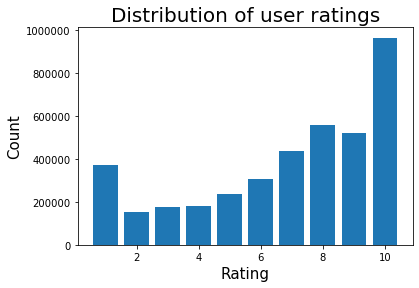

In [62]:
# create histogram of all user ratings
numbers = [x for l in ratings_dict.values() for x in l if not math.isnan(x)] 

bin_counts, bin_edges = np.histogram(numbers, bins=10)
plt.bar(range(1,11), bin_counts, width=0.8)
plt.xlabel('Rating', size=15)
plt.ylabel('Count', size=15)
plt.title('Distribution of user ratings', size=20)
plt.show()

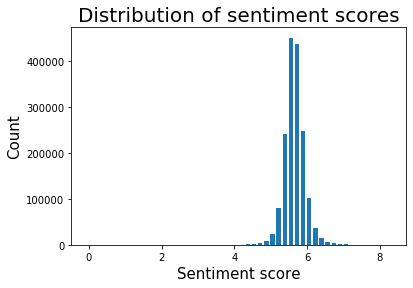

In [63]:
#sentiments[row['tconst']].append(h_avg(cleaned_text))

# create histogram of sentiment distribution
all_sentiments = [x for l in sentiments.values() for x in l if not math.isnan(x)] 

bin_counts, bin_edges = np.histogram(all_sentiments, bins=50)
plt.bar(bin_edges[:-1], bin_counts, width=0.12)
plt.xlabel('Sentiment score', size=15)
plt.ylabel('Count', size=15)
plt.title('Distribution of sentiment scores', size=20)
plt.show()

In [64]:
std_dev = np.std(all_sentiments)
avg_sentiment = sum(all_sentiments) / len(all_sentiments)
print("Standard deviation in sentiment is", std_dev)
print("Average sentiment score is", avg_sentiment)

Standard deviation in sentiment is 0.28402106255435455
Average sentiment score is 5.740324053412721


# Contributions

Although it is difficult to pinpoint exactly who made the specific parts as we have worked closely on the entire project, but we can separate the main responsibilities between the two involved parties as such:

- *Kasper Lindegaard Stilling, s141250* - Website template, processing of the IMDb dataset, web scraper, natural language processing
- *Sebastian Lindhard Budsted, s135243* - Processing of the IMDb dataset, graphs and community detection